In [ ]:
# Another simple RNN for time series prediction (on synthetic data)
# https://github.com/Nishil07/Simple-Rnn-for-my-first-Medium-blog/blob/master/Simple_RNN.ipynb
# Arpil 2022

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline

[0.00000000e+00 1.56434465e-01 3.09016994e-01 4.53990500e-01
 5.87785252e-01 7.07106781e-01 8.09016994e-01 8.91006524e-01
 9.51056516e-01 9.87688341e-01 1.00000000e+00 9.87688341e-01
 9.51056516e-01 8.91006524e-01 8.09016994e-01 7.07106781e-01
 5.87785252e-01 4.53990500e-01 3.09016994e-01 1.56434465e-01
 1.22464680e-16]
[[0.00000000e+00]
 [1.56434465e-01]
 [3.09016994e-01]
 [4.53990500e-01]
 [5.87785252e-01]
 [7.07106781e-01]
 [8.09016994e-01]
 [8.91006524e-01]
 [9.51056516e-01]
 [9.87688341e-01]
 [1.00000000e+00]
 [9.87688341e-01]
 [9.51056516e-01]
 [8.91006524e-01]
 [8.09016994e-01]
 [7.07106781e-01]
 [5.87785252e-01]
 [4.53990500e-01]
 [3.09016994e-01]
 [1.56434465e-01]
 [1.22464680e-16]]


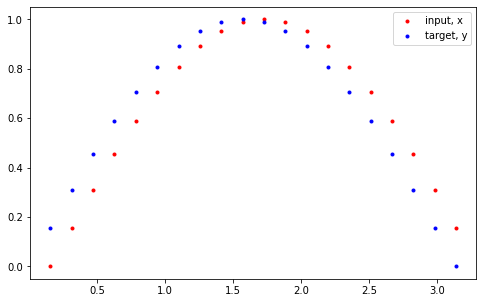

In [11]:
# generate some synthetic data
# how many time steps/data pts are in one batch of data
seq_length = 20

# ensure evenly spaced data points
time_steps = np.linspace(0, np.pi, seq_length + 1)
data = np.sin(time_steps)
print(data)

data.resize((seq_length + 1, 1)) # size becomes (seq_length+1, 1), adds an input_size dimension
print(data)

#input data
x = data[:-1] # all but the last piece of data
#target data
y = data[1:] # all but the first

# display the data
plt.figure(figsize=(8,5))
plt.plot(time_steps[1:], x, 'r.', label='input, x') # x
plt.plot(time_steps[1:], y, 'b.', label='target, y') # y

plt.legend(loc='best')
plt.show()

Define the RNN
Next, we define an RNN in PyTorch. We'll use nn.RNN to create an RNN layer, then we'll add a last, fully-connected layer to get the output size that we want. An RNN takes in a number of parameters:

input_size - the size of the input

hidden_dim - the number of features in the RNN output and in the hidden state

n_layers - the number of layers that make up the RNN, typically 1-3; greater than 1 means that you'll create a stacked RNN

batch_first - whether or not the input/output of the RNN will have the 
batch_size as the first dimension (batch_size, seq_length, hidden_dim)

In [3]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim=hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        
        r_out = r_out.view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.fc(r_out)
        
        return output, hidden

In [ ]:
# decide on hyperparameters
input_size=1 
output_size=1
hidden_dim=32
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

Loss and Optimization

This is a regression problem: can we train an RNN to accurately predict the next data point, given a current data point?


The data points are coordinate values, so to compare a predicted and ground_truth point, we'll use a regression loss: the mean squared error.
It's typical to use an Adam optimizer for recurrent models.

In [5]:
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01) 

In [6]:
# Before looping over a batch of training data, the hidden state is initialized
# After a new hidden state is generated by the rnn, we get the latest hidden state, and use that as input to the rnn for the following steps

# train the RNN
def train(rnn, n_steps, print_every):
    
    # initialize the hidden state
    hidden = None      
    
    for batch_i, step in enumerate(range(n_steps)):
        # define the training data 
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize((seq_length + 1, 1)) # input_size=1

        x = data[:-1]
        y = data[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.')                                 # input x is red
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions are blue
            plt.show()
    
    return (rnn)

Loss:  0.004068564623594284


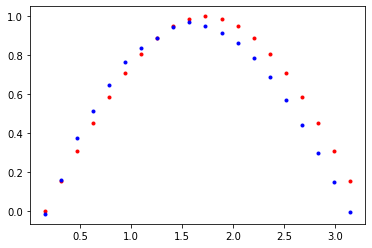

Loss:  0.0002670748217497021


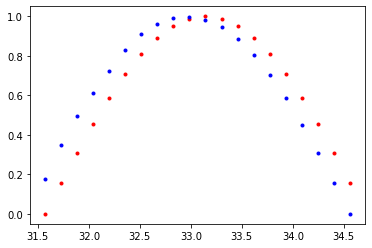

Loss:  0.0004297913983464241


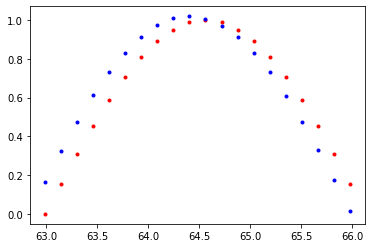

Loss:  1.9664572391775437e-05


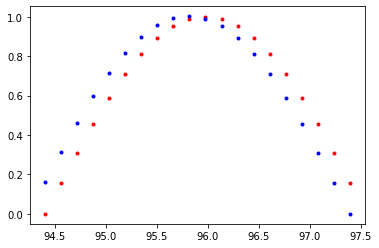

Loss:  7.583525984955486e-06


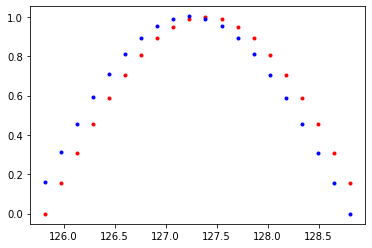

Loss:  2.786818413369474e-06


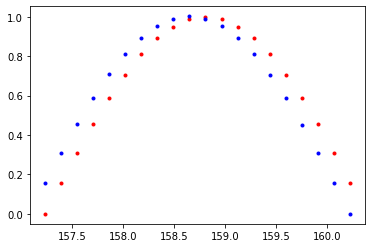

Loss:  3.097737589996541e-06


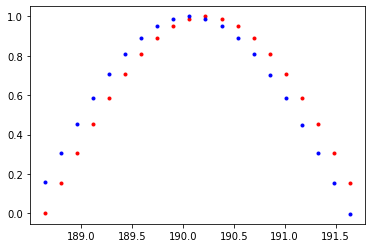

Loss:  9.537216101307422e-07


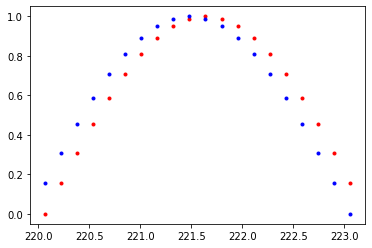

In [10]:
# train the rnn and monitor results
n_steps = 80
print_every = 10

trained_rnn = train(rnn, n_steps, print_every)